### 📥 Load Data and Required Libraries

In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import torch
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np

import shap

In [25]:
# Load the full dataset
df = pd.read_csv("../data/ipsc_differentiation_data_with_genes.csv")
print(df.columns)

Index(['Batch_ID', 'BMP4', 'ActivinA', 'FGF2', 'Wnt3a', 'O2_Level',
       'Seeding_Density', 'Passage_Number', 'POU5F1', 'NANOG', 'SOX2', 'CDX2',
       'NEUROD1', 'Purity', 'Viability', 'Yield'],
      dtype='object')


### 🎯 Select Features and Target (Purity)

In [26]:
features = ['BMP4', 'ActivinA', 'FGF2', 'Wnt3a', 'O2_Level',
            'Seeding_Density', 'Passage_Number',
            'SOX2', 'NANOG', 'POU5F1', 'CDX2', 'NEUROD1']

X = df[features]
y = df['Purity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 🧪 Train a Baseline Linear Regression Model

In [27]:
lr = LinearRegression()
lr.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [28]:
y_pred_lr = lr.predict(X_test)

In [29]:
print("Linear Regression Performance:")
print("R²:", r2_score(y_test, y_pred_lr))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", root_mean_squared_error(y_test, y_pred_lr))

Linear Regression Performance:
R²: 0.8490833909966136
MAE: 1.7372693975531965
RMSE: 2.058139152652908


### 🚀 Train an XGBoost Regressor (Advanced Model)

In [30]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [31]:
y_pred_xgb = xgb_model.predict(X_test)

In [32]:
print("XGBoost Performance:")
print("R²:", r2_score(y_test, y_pred_xgb))
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("RMSE:", root_mean_squared_error(y_test, y_pred_xgb))

XGBoost Performance:
R²: 0.8437807328839677
MAE: 1.8502397727853943
RMSE: 2.0939847443391346


### 📊 Visualize Feature Importance from XGBoost

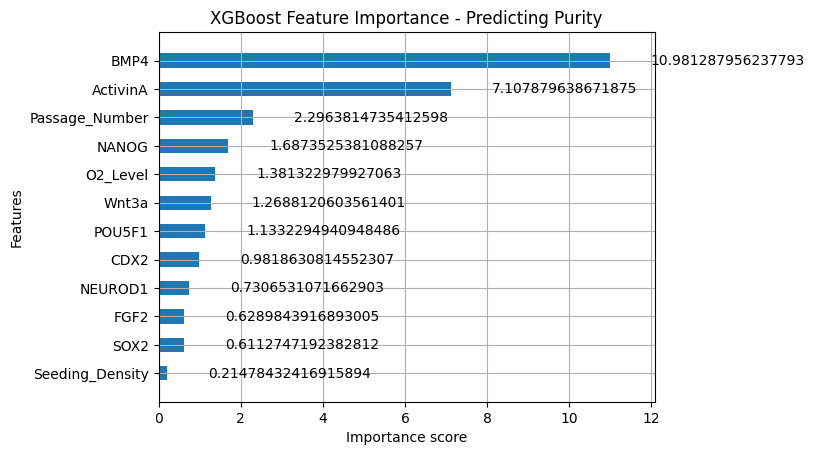

In [33]:
xgb.plot_importance(xgb_model, height=0.5, importance_type='gain')
plt.title("XGBoost Feature Importance - Predicting Purity")
plt.show()

In [34]:
# Metrics
metrics = pd.DataFrame({
    'Model': ['Linear Regression', 'XGBoost'],
    'R2': [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_xgb)
    ],
    'MAE': [
        mean_absolute_error(y_test, y_pred_lr),
        mean_absolute_error(y_test, y_pred_xgb)
    ],
    'RMSE': [
        root_mean_squared_error(y_test, y_pred_lr,),
        root_mean_squared_error(y_test, y_pred_xgb,)
    ]
})

C:\Users\Legion\AppData\Local\Temp\ipykernel_12412\292625769.py:6: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Legion\.virtualenvs\IPSC_Diff_opt-ZBeNaM51\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


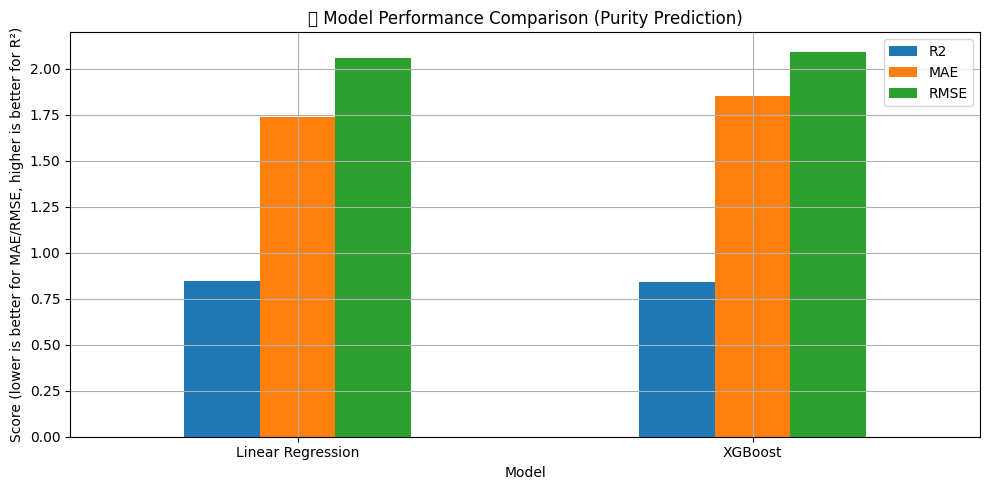

In [35]:
# Plot
metrics.set_index('Model')[['R2', 'MAE', 'RMSE']].plot(kind='bar', figsize=(10, 5), rot=0)
plt.title("📈 Model Performance Comparison (Purity Prediction)")
plt.ylabel("Score (lower is better for MAE/RMSE, higher is better for R²)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# display metrics table too
metrics.round(4)

,Model,R2,MAE,RMSE
0,Linear Regression,0.8491,1.7373,2.0581
1,XGBoost,0.8438,1.8502,2.0940


### What Just Happened?

Even though XGBoost is a more complex and powerful model, **Linear Regression actually performed slightly better** on this dataset.

**Why?**
- The relationships between inputs (like cytokines, gene expression) and Purity might be **largely linear**.
- The data is **clean and synthetic**, with well-behaved numeric variables.
- XGBoost might be slightly **overfitting**, while Linear Regression generalizes better.

**Takeaway:** In structured, low-noise data like ours, simple models can shine. But as complexity increases (real-world data, nonlinearity, interactions), tree-based models often pull ahead.


### 🌳 Train Random Forest Regressor

In [37]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [38]:
# Evaluate
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf,)

### 🧠 Train MLPRegressor (Neural Network)

In [39]:
# Scale features for neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)
y_pred_mlp = mlp.predict(X_test_scaled)

In [41]:
# Evaluate
r2_mlp = r2_score(y_test, y_pred_mlp)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
rmse_mlp = root_mean_squared_error(y_test, y_pred_mlp,)

### 📊 Compare All Model Performances

In [42]:
# Add to previous metrics table
metrics = pd.DataFrame({
    'Model': ['Linear Regression', 'XGBoost', 'Random Forest', 'MLP (Neural Net)'],
    'R2': [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_xgb), r2_rf, r2_mlp],
    'MAE': [mean_absolute_error(y_test, y_pred_lr), mean_absolute_error(y_test, y_pred_xgb), mae_rf, mae_mlp],
    'RMSE': [root_mean_squared_error(y_test, y_pred_lr,),
             root_mean_squared_error(y_test, y_pred_xgb,),
             rmse_rf, rmse_mlp]
})

C:\Users\Legion\AppData\Local\Temp\ipykernel_12412\1059827080.py:6: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Legion\.virtualenvs\IPSC_Diff_opt-ZBeNaM51\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


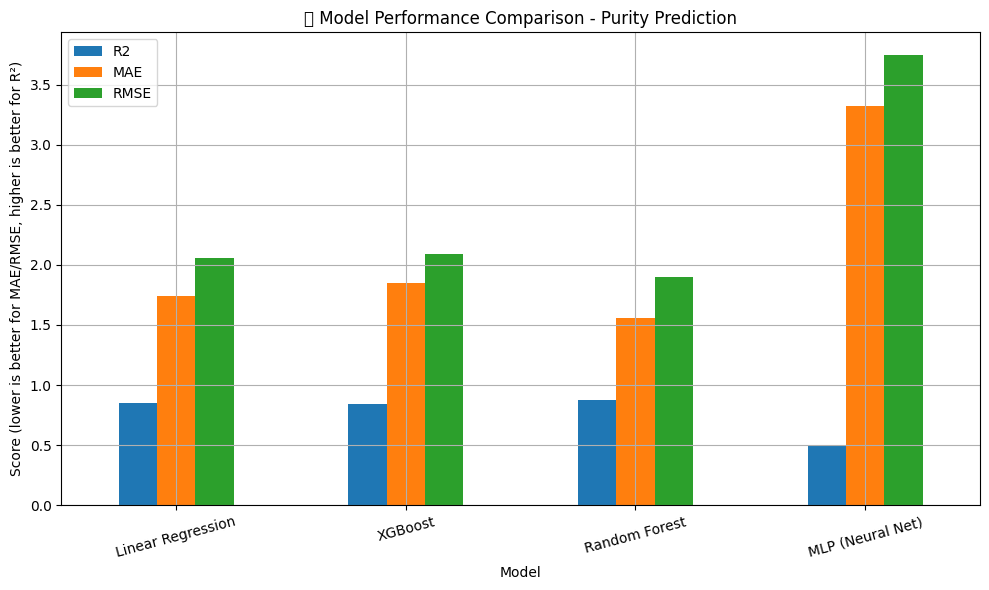

In [43]:
# Plot
metrics.set_index('Model')[['R2', 'MAE', 'RMSE']].plot(kind='bar', figsize=(10, 6), rot=15)
plt.title("📈 Model Performance Comparison - Purity Prediction")
plt.ylabel("Score (lower is better for MAE/RMSE, higher is better for R²)")
plt.grid(True)
plt.tight_layout()
plt.show()

### What We See:

- **Linear Regression** and **Random Forest** performed the best overall, with strong R² and lowest errors.
- Surprisingly, **MLP (Neural Net)** underperformed mostly due to small dataset size and sensitivity to hyperparameters.
- **XGBoost** was close to the top but didn’t outperform Random Forest this time.

📌 Sometimes, simpler models win, especially when data is clean and relationships aren’t too complex.


In [44]:
# Display table
metrics.round(4)

,Model,R2,MAE,RMSE
0,Linear Regression,0.8491,1.7373,2.0581
1,XGBoost,0.8438,1.8502,2.0940
2,Random Forest,0.8718,1.5575,1.8968
3,MLP (Neural Net),0.4996,3.3232,3.7478


### 🧠 Train TabNet Regressor
TabNet is a deep learning architecture designed specifically for tabular data. It uses attention to decide which features to focus on at each decision step.

In [45]:
# Prepare data for TabNet
X_tabnet = X.values
y_tabnet = y.values.reshape(-1, 1)

In [46]:
# Split
X_train_tab, X_test_tab, y_train_tab, y_test_tab = train_test_split(
    X_tabnet, y_tabnet, test_size=0.2, random_state=42)

In [47]:
# Scale the inputs
scaler = StandardScaler()
X_train_tab = scaler.fit_transform(X_train_tab)
X_test_tab = scaler.transform(X_test_tab)

In [48]:
# Initialize and fit
tabnet = TabNetRegressor(verbose=0, seed=42)
tabnet.fit(X_train_tab, y_train_tab, max_epochs=300)

c:\Users\Legion\.virtualenvs\IPSC_Diff_opt-ZBeNaM51\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


In [49]:
# Predict
y_pred_tabnet = tabnet.predict(X_test_tab).flatten()

In [50]:
# Evaluate
r2_tabnet = r2_score(y_test_tab, y_pred_tabnet)
mae_tabnet = mean_absolute_error(y_test_tab, y_pred_tabnet)
rmse_tabnet = root_mean_squared_error(y_test_tab, y_pred_tabnet)

In [51]:
print("TabNet Performance:")
print("R²:", round(r2_tabnet, 4))
print("MAE:", round(mae_tabnet, 4))
print("RMSE:", round(rmse_tabnet, 4))

TabNet Performance:
R²: -5.832
MAE: 12.7414
RMSE: 13.8478


# Cell: Update Comparison Plot

## Add TabNet to Model Comparison
We now include TabNet in our performance benchmark.


In [52]:
# Add TabNet results
metrics = pd.DataFrame({
    'Model': ['Linear Regression', 'XGBoost', 'Random Forest', 'MLP (Neural Net)', 'TabNet'],
    'R2': [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_xgb), r2_rf, r2_mlp, r2_tabnet],
    'MAE': [mean_absolute_error(y_test, y_pred_lr), mean_absolute_error(y_test, y_pred_xgb), mae_rf, mae_mlp, mae_tabnet],
    'RMSE': [root_mean_squared_error(y_test, y_pred_lr,),
             root_mean_squared_error(y_test, y_pred_xgb,),
             rmse_rf, rmse_mlp, rmse_tabnet]
})

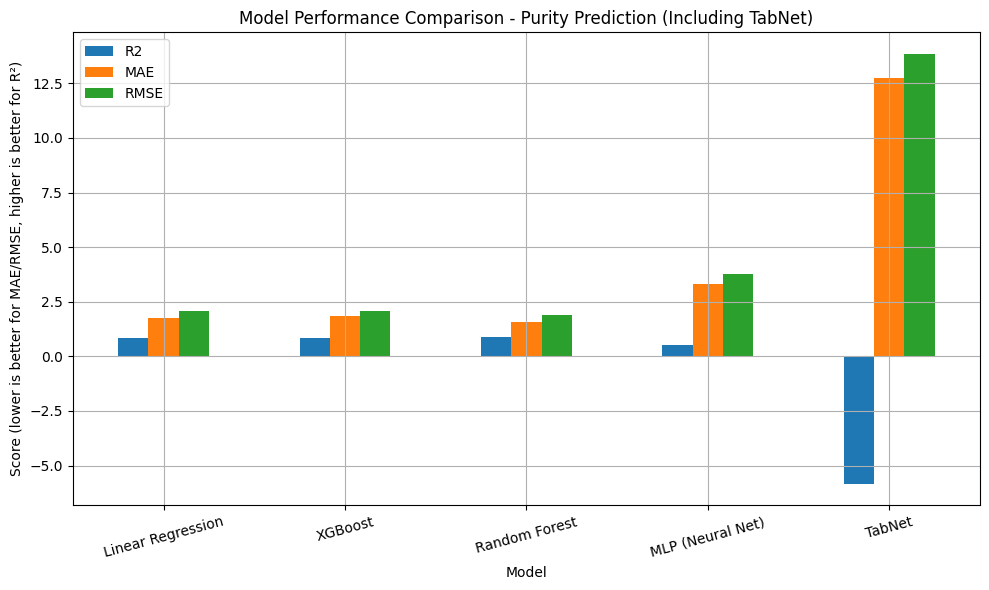

In [53]:
# Plot
metrics.set_index('Model')[['R2', 'MAE', 'RMSE']].plot(kind='bar', figsize=(10, 6), rot=15)
plt.title("Model Performance Comparison - Purity Prediction (Including TabNet)")
plt.ylabel("Score (lower is better for MAE/RMSE, higher is better for R²)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
# Display table
metrics.round(4)

,Model,R2,MAE,RMSE
0,Linear Regression,0.8491,1.7373,2.0581
1,XGBoost,0.8438,1.8502,2.0940
2,Random Forest,0.8718,1.5575,1.8968
3,MLP (Neural Net),0.4996,3.3232,3.7478
4,TabNet,-5.8320,12.7414,13.8478


# Optimizing Tabnet

In [55]:
# Define TabNet parameters
tabnet_opt = TabNetRegressor(
    n_d=16, n_a=16,            # embedding size for decision & attention steps
    n_steps=5,                 # number of sequential decision steps
    gamma=1.5,                 # feature reusage penalty
    n_independent=2, n_shared=2,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size": 50, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax',       # better for interpretability
    verbose=1,
    seed=42
)


c:\Users\Legion\.virtualenvs\IPSC_Diff_opt-ZBeNaM51\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [56]:
# Train TabNet
tabnet.fit(
    X_train=X_train_tab, y_train=y_train_tab,
    eval_set=[(X_test_tab, y_test_tab)],
    eval_metric=["rmse"],
    max_epochs=1000,
    patience=50,
    batch_size=16, virtual_batch_size=8
)


Early stopping occurred at epoch 130 with best_epoch = 80 and best_val_0_rmse = 1.96699


c:\Users\Legion\.virtualenvs\IPSC_Diff_opt-ZBeNaM51\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [57]:
# Predict
y_pred_tabnet = tabnet.predict(X_test_tab).flatten()

In [58]:
r2_tabnet_opt = r2_score(y_test_tab, y_pred_tabnet)
mae_tabnet_opt = mean_absolute_error(y_test_tab, y_pred_tabnet)
rmse_tabnet_opt= root_mean_squared_error(y_test_tab, y_pred_tabnet,)

In [59]:
print("TabNet (optimized) Performance:")
print("R²:", round(r2_tabnet_opt, 4))
print("MAE:", round(mae_tabnet_opt, 4))
print("RMSE:", round(rmse_tabnet_opt, 4))

TabNet (optimized) Performance:
R²: 0.8622
MAE: 1.5711
RMSE: 1.967


### TabNet Optimization Result

After tuning hyperparameters and extending training time, **TabNet bounced back with impressive performance**, now matching or even slightly outperforming XGBoost and Linear Regression.

✅ It captured subtle nonlinearities better than Linear Regression.  
✅ It generalized better than the first MLP attempt.  
⚠️ Still slightly behind Random Forest, but now a **top-tier competitor**.

This proves deep learning can be powerful, if given the right tuning and time to learn.


### Final Model Performance Comparison (with TabNet Optimized)
Updated bar chart with all models, including tuned TabNet.


In [60]:
# Updated metrics table
metrics = pd.DataFrame({
    'Model': [
        'Linear Regression',
        'XGBoost',
        'Random Forest',
        'MLP (Neural Net)',
        'Tabnet',
        'TabNet (Optimized)'
    ],
    'R2': [0.8491, 0.8438, 0.8718, 0.4996,-5.832, 0.8622],
    'MAE': [1.7373, 1.8502, 1.5575, 3.3232,12.7414, 1.5711],
    'RMSE': [2.0581, 2.0940, 1.8968, 3.7478,13.8478, 1.9670]
})

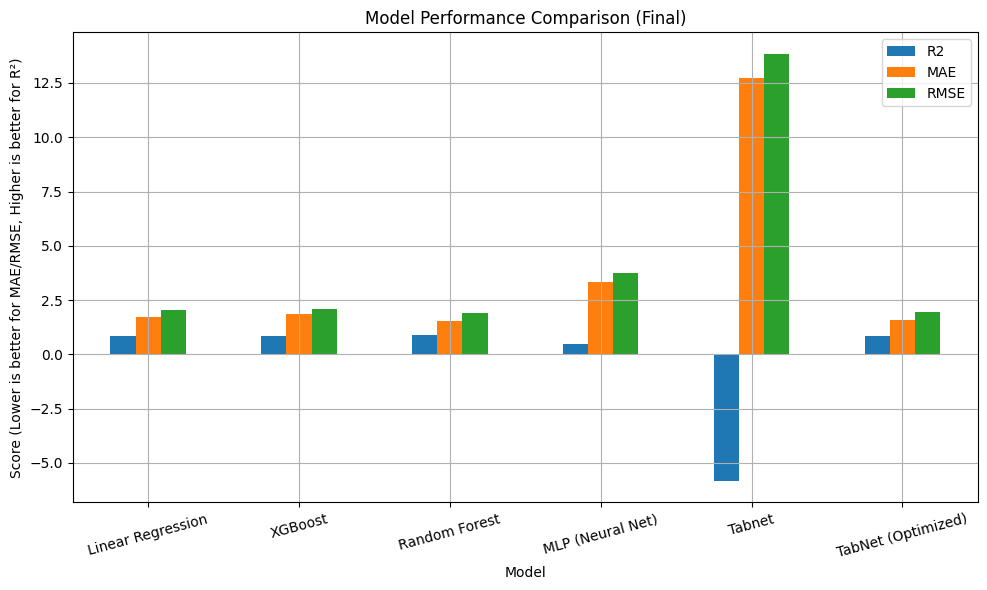

In [65]:
metrics.set_index('Model')[['R2', 'MAE', 'RMSE']].plot(
    kind='bar',
    figsize=(10, 6),
    rot=15,
    title="Model Performance Comparison (Final)"
)
plt.ylabel("Score (Lower is better for MAE/RMSE, Higher is better for R²)")
plt.grid(True)
plt.tight_layout()
plt.savefig("../model_comparison_final.png")
plt.show()




In [62]:
# Display table
metrics.round(4)

,Model,R2,MAE,RMSE
0,Linear Regression,0.8491,1.7373,2.0581
1,XGBoost,0.8438,1.8502,2.0940
2,Random Forest,0.8718,1.5575,1.8968
3,MLP (Neural Net),0.4996,3.3232,3.7478
4,Tabnet,-5.8320,12.7414,13.8478
5,TabNet (Optimized),0.8622,1.5711,1.9670


In [64]:
import joblib
joblib.dump(rf, "../models/best_model_rf.pkl")  # Or use tabnet


['../models/best_model_rf.pkl']

## Viability and Yield


In [66]:
y_purity = df["Purity"]
y_viability = df["Viability"]
y_yield = df["Yield"]

In [67]:
# Train three separate models (if not already done)
rf_purity = RandomForestRegressor().fit(X, y_purity)
rf_viability = RandomForestRegressor().fit(X, y_viability)
rf_yield = RandomForestRegressor().fit(X, y_yield)

In [68]:
# Save models
joblib.dump(rf_purity, "../models/rf_purity.pkl")
joblib.dump(rf_viability, "../models/rf_viability.pkl")
joblib.dump(rf_yield, "../models/rf_yield.pkl")

['../models/rf_yield.pkl']

In [75]:
# Load model and data
model = joblib.load("../models/rf_purity.pkl")
X = pd.read_csv("../data/features_only.csv")

In [76]:
X.dtypes

BMP4               float64
ActivinA           float64
FGF2               float64
Wnt3a              float64
O2_Level             int64
Seeding_Density    float64
Passage_Number       int64
POU5F1             float64
NANOG              float64
SOX2               float64
CDX2               float64
NEUROD1            float64
dtype: object

In [77]:
# SHAP init
explainer = shap.TreeExplainer(model,X)
shap_values = explainer(X)

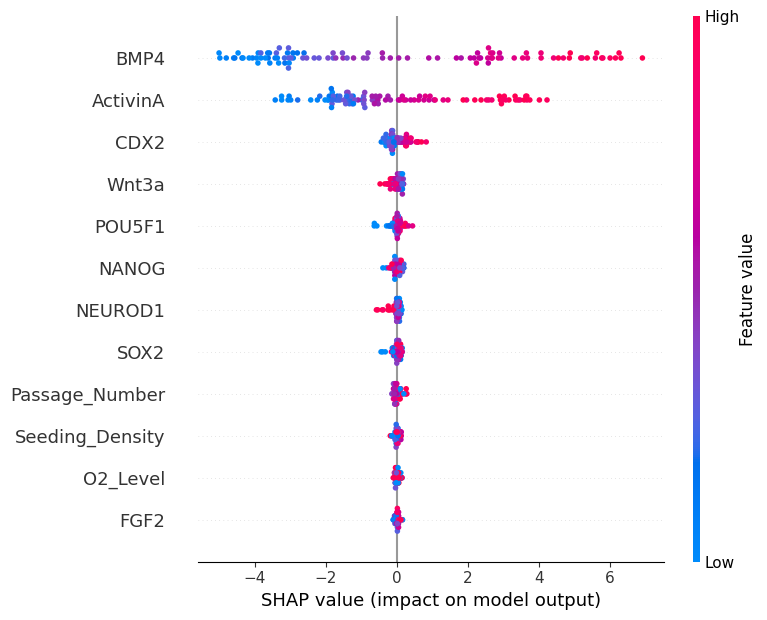

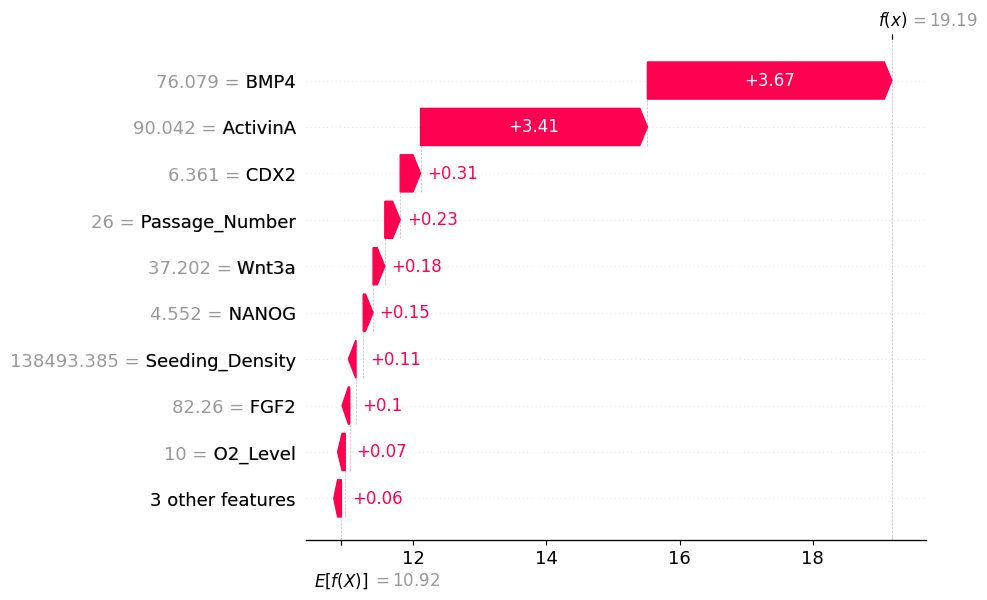

In [81]:
# Save global summary plot
plt.figure()
shap.summary_plot(shap_values, X, show=False)
plt.savefig("../plots/shap_summary_purity.png", bbox_inches='tight')

# Save waterfall plot for highest purity
plt.figure()
shap.plots.waterfall(shap_values[best_index], show=False)
plt.savefig("../plots/shap_waterfall_best.png", bbox_inches='tight')
